utilized from optuna for hyper parameter optimization technic.

and enhance performance of lstm model via best params

In [ ]:
# Import Required Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix as sk_confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import IsolationForest
import os
import optuna
import seaborn as sns
import json
import sys
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# Add the parent directory to the Python path
sys.path.append('../') 
from models.lstm_forecast_model import LSTMForecast
from models.timeseries_dataset_class import TimeSeriesDataset

# ✅ Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

In [ ]:

# SMAPE calculation
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

In [ ]:
# Evaluate model
def evaluate_model(model, dataloader, title, plot_name, writer=None, step=0):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            all_preds.append(pred)
            all_trues.append(y.numpy())
    predictions = np.concatenate(all_preds)
    truths = np.concatenate(all_trues)

    plt.figure(figsize=(10, 5))
    plt.plot(truths[:100], label="True")
    plt.plot(predictions[:100], label="Predicted")
    plt.legend()
    plt.title(title)
    plt.grid(True)
    os.makedirs("../../outputs/LSTM_Model", exist_ok=True)
    plot_path = f"../../outputs/LSTM_Model/{plot_name}"
    plt.savefig(plot_path)
    plt.show()
    print(f"✅ Plot saved to outputs/{plot_name}")

    mse = mean_squared_error(truths, predictions)
    mae = mean_absolute_error(truths, predictions)
    smape_val = smape(truths, predictions)
    print(f"📊 {title} Metrics:")
    print(f" - MSE   : {mse:.6f}")
    print(f" - MAE   : {mae:.6f}")
    print(f" - SMAPE : {smape_val:.2f}%")

    if writer:
        writer.add_scalar("Metrics/MSE", mse, step)
        writer.add_scalar("Metrics/MAE", mae, step)
        writer.add_scalar("Metrics/SMAPE", smape_val, step)

    return predictions, truths

In [ ]:
# Anomaly scoring based on residual thresholding
def anomaly_score(y_true, y_pred, threshold=3.0):

    # Ensure y_true and y_pred are 1D arrays with flattening or squeezing
    if y_true.ndim > 1:
        y_true = y_true.flatten()
    if y_pred.ndim > 1:
        y_pred = y_pred.flatten()

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape for anomaly detection.")

    residual = np.abs(y_true - y_pred)
    mean = np.mean(residual)
    std = np.std(residual)
    z_score = (residual - mean) / std
    anomalies = np.where(np.abs(z_score) > threshold)[0]


    plt.figure(figsize=(15, 5))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.scatter(anomalies, y_true[anomalies], color='red', label='Anomalies')
    plt.title("Anomaly Detection Result via z-score")
    plt.legend()
    plt.grid(True)
    plt.savefig("../../outputs/LSTM_Model/anomaly_detection_visual_z_score.png")
    plt.show()
    print("✅ Anomaly plot saved to anomaly_detection_visual_z_score.png")

    # Automatic anomaly description
    for idx in anomalies[:5]:
        true_val = float(np.ravel(y_true[idx])[0])
        pred_val = float(np.ravel(y_pred[idx])[0])
        z_val = float(np.ravel(z_score[idx])[0])
        print(f"⚠️ Anomaly at index {idx} → True: {true_val:.2f}, Predicted: {pred_val:.2f}, Z-score: {z_val:.2f}")
        
    return anomalies, z_score

In [ ]:
# Isolation Forest (optional advanced detector)
def isolation_forest_detection(residuals):
    iso = IsolationForest(contamination=0.01)
    preds = iso.fit_predict(residuals.reshape(-1, 1))
    anomalies = np.where(preds == -1)[0]
    return anomalies


In [ ]:
#  Isolation Forest Visualization
def visualize_isolation_forest_anomalies(y_true, y_pred, iso_anomalies):
    # Filter out-of-bounds indices
    iso_anomalies = [idx for idx in iso_anomalies if idx < len(y_true)]
    
    plt.figure(figsize=(15, 5))
    plt.plot(y_true, label="True")
    plt.plot(y_pred, label="Predicted")

    plt.scatter(iso_anomalies, y_true[iso_anomalies], color="green", label="ISO Anomalies")

    plt.title("Isolation Forest - Anomaly Detection")
    plt.legend()
    plt.grid(True)

    iso_plot_path = "../../outputs/LSTM_Model/isolation_forest_anomaly_plot.png"
    plt.savefig(iso_plot_path)
    plt.show()
    print(f"✅ Isolation Forest anomaly plot saved to: {iso_plot_path}")

    for idx in iso_anomalies[:5]:
        true_val = float(np.ravel(y_true[idx])[0])
        pred_val = float(np.ravel(y_pred[idx])[0])
        residual_val = float(np.ravel(np.abs(y_true[idx] - y_pred[idx]))[0])
        print(f"🌪️ ISO Anomaly at index {idx} → True: {true_val:.2f}, Predicted: {pred_val:.2f}, Residual: {residual_val:.2f}")


In [ ]:
# Train and evaluate with early stopping
def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, epochs=50, early_stop=5, writer=SummaryWriter(log_dir="../runs/LSTM_Model/train_and_eval")):
    best_val_loss = float('inf')
    patience = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).unsqueeze(1)
            optimizer.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        # writer.add_scalar("Loss/train", avg_train_loss, epoch)
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device).unsqueeze(1)
                val_loss += loss_fn(model(x), y).item()
        avg_val_loss = val_loss / len(val_loader)
        # writer.add_scalar("Loss/val", avg_val_loss, epoch)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience = 0
        else:
            patience += 1
            if patience >= early_stop:
                break
    # writer.close()
    return best_val_loss

In [ ]:
# Optuna objective function
def objective(trial):
    window_size = trial.suggest_int("window_size", 24, 512)
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
    val_df = pd.read_csv("../data/processed/etth1_val.csv", parse_dates=["date"], index_col="date")
    train_target = train_df["OT"].values
    val_target = val_df["OT"].values

    train_loader = DataLoader(TimeSeriesDataset(train_target, window_size), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TimeSeriesDataset(val_target, window_size), batch_size=batch_size, shuffle=False)

    model = LSTMForecast(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    return train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn)


In [14]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[Epoch 9] Train Loss: 0.0020
[Epoch 10] Train Loss: 0.0020
[Epoch 10] Train Loss: 0.0020
[Epoch 11] Train Loss: 0.0019
[Epoch 11] Train Loss: 0.0019
[Epoch 12] Train Loss: 0.0018
[Epoch 12] Train Loss: 0.0018
[Epoch 13] Train Loss: 0.0018
[Epoch 13] Train Loss: 0.0018
[Epoch 14] Train Loss: 0.0017
[Epoch 14] Train Loss: 0.0017
[Epoch 15] Train Loss: 0.0016
[Epoch 15] Train Loss: 0.0016
[Epoch 16] Train Loss: 0.0016
[Epoch 16] Train Loss: 0.0016
[Epoch 17] Train Loss: 0.0015
[Epoch 17] Train Loss: 0.0015
[Epoch 18] Train Loss: 0.0014
[Epoch 18] Train Loss: 0.0014
[Epoch 19] Train Loss: 0.0014
[Epoch 19] Train Loss: 0.0014
[Epoch 20] Train Loss: 0.0013
[Epoch 20] Train Loss: 0.0013
[Epoch 21] Train Loss: 0.0012
[Epoch 21] Train Loss: 0.0012
[Epoch 22] Train Loss: 0.0011
[Epoch 22] Train Loss: 0.0011
[Epoch 23] Train Loss: 0.0010
[Epoch 23] Train Loss: 0.0010
[Epoch 24] Train Loss: 0.0010
[Epoch 24] Train Loss: 0.0010
[Epoch 25] Train Loss: 0.0010
[Epoch 25] Train Loss: 0.0010
[Epoch 26] 

[I 2025-07-21 09:19:52,099] Trial 0 finished with value: 0.00019193238683958323 and parameters: {'window_size': 125, 'hidden_size': 75, 'num_layers': 3, 'dropout': 0.2243836366813993, 'lr': 0.00024557522309126865, 'batch_size': 128}. Best is trial 0 with value: 0.00019193238683958323.


[Epoch 50] Train Loss: 0.0005


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24052261416851822 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0784
[Epoch 2] Train Loss: 0.0073
[Epoch 2] Train Loss: 0.0073
[Epoch 3] Train Loss: 0.0032
[Epoch 3] Train Loss: 0.0032
[Epoch 4] Train Loss: 0.0026
[Epoch 4] Train Loss: 0.0026
[Epoch 5] Train Loss: 0.0022
[Epoch 5] Train Loss: 0.0022
[Epoch 6] Train Loss: 0.0020
[Epoch 6] Train Loss: 0.0020
[Epoch 7] Train Loss: 0.0018
[Epoch 7] Train Loss: 0.0018
[Epoch 8] Train Loss: 0.0017
[Epoch 8] Train Loss: 0.0017
[Epoch 9] Train Loss: 0.0016
[Epoch 9] Train Loss: 0.0016
[Epoch 10] Train Loss: 0.0016
[Epoch 10] Train Loss: 0.0016
[Epoch 11] Train Loss: 0.0015
[Epoch 11] Train Loss: 0.0015
[Epoch 12] Train Loss: 0.0014
[Epoch 12] Train Loss: 0.0014
[Epoch 13] Train Loss: 0.0014
[Epoch 13] Train Loss: 0.0014
[Epoch 14] Train Loss: 0.0014
[Epoch 14] Train Loss: 0.0014
[Epoch 15] Train Loss: 0.0013
[Epoch 15] Train Loss: 0.0013
[Epoch 16] Train Loss: 0.0012
[Epoch 16] Train Loss: 0.0012
[Epoch 17] Train Loss: 0.0012
[Epoch 17] Train Loss: 0.0012
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:21:21,940] Trial 1 finished with value: 0.00020756142506191585 and parameters: {'window_size': 233, 'hidden_size': 51, 'num_layers': 1, 'dropout': 0.24052261416851822, 'lr': 0.00014370366223589312, 'batch_size': 64}. Best is trial 0 with value: 0.00019193238683958323.


[Epoch 50] Train Loss: 0.0004
[Epoch 1] Train Loss: 0.0137
[Epoch 1] Train Loss: 0.0137
[Epoch 2] Train Loss: 0.0019
[Epoch 2] Train Loss: 0.0019
[Epoch 3] Train Loss: 0.0016
[Epoch 3] Train Loss: 0.0016
[Epoch 4] Train Loss: 0.0012
[Epoch 4] Train Loss: 0.0012
[Epoch 5] Train Loss: 0.0010
[Epoch 5] Train Loss: 0.0010
[Epoch 6] Train Loss: 0.0010
[Epoch 6] Train Loss: 0.0010
[Epoch 7] Train Loss: 0.0009
[Epoch 7] Train Loss: 0.0009
[Epoch 8] Train Loss: 0.0008
[Epoch 8] Train Loss: 0.0008
[Epoch 9] Train Loss: 0.0008
[Epoch 9] Train Loss: 0.0008
[Epoch 10] Train Loss: 0.0007
[Epoch 10] Train Loss: 0.0007
[Epoch 11] Train Loss: 0.0007
[Epoch 11] Train Loss: 0.0007
[Epoch 12] Train Loss: 0.0007
[Epoch 12] Train Loss: 0.0007
[Epoch 13] Train Loss: 0.0007
[Epoch 13] Train Loss: 0.0007
[Epoch 14] Train Loss: 0.0007
[Epoch 14] Train Loss: 0.0007
[Epoch 15] Train Loss: 0.0007
[Epoch 15] Train Loss: 0.0007
[Epoch 16] Train Loss: 0.0007
[Epoch 16] Train Loss: 0.0007
[Epoch 17] Train Loss: 0.000

[I 2025-07-21 09:21:44,795] Trial 2 finished with value: 0.00019923185531157427 and parameters: {'window_size': 112, 'hidden_size': 36, 'num_layers': 3, 'dropout': 0.47476255891954844, 'lr': 0.007406899223467363, 'batch_size': 128}. Best is trial 0 with value: 0.00019193238683958323.


[Epoch 18] Train Loss: 0.0007
[Epoch 1] Train Loss: 0.0076
[Epoch 1] Train Loss: 0.0076
[Epoch 2] Train Loss: 0.0013
[Epoch 2] Train Loss: 0.0013
[Epoch 3] Train Loss: 0.0010
[Epoch 3] Train Loss: 0.0010
[Epoch 4] Train Loss: 0.0008
[Epoch 4] Train Loss: 0.0008
[Epoch 5] Train Loss: 0.0007
[Epoch 5] Train Loss: 0.0007
[Epoch 6] Train Loss: 0.0006
[Epoch 6] Train Loss: 0.0006
[Epoch 7] Train Loss: 0.0005
[Epoch 7] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0005
[Epoch 9] Train Loss: 0.0005
[Epoch 9] Train Loss: 0.0005
[Epoch 10] Train Loss: 0.0005
[Epoch 10] Train Loss: 0.0005
[Epoch 11] Train Loss: 0.0005
[Epoch 11] Train Loss: 0.0005


[I 2025-07-21 09:22:22,598] Trial 3 finished with value: 0.00019841067587549331 and parameters: {'window_size': 511, 'hidden_size': 80, 'num_layers': 2, 'dropout': 0.3252565316467131, 'lr': 0.0021334697528785974, 'batch_size': 64}. Best is trial 0 with value: 0.00019193238683958323.


[Epoch 12] Train Loss: 0.0005
[Epoch 1] Train Loss: 0.0070
[Epoch 1] Train Loss: 0.0070
[Epoch 2] Train Loss: 0.0014
[Epoch 2] Train Loss: 0.0014
[Epoch 3] Train Loss: 0.0010
[Epoch 3] Train Loss: 0.0010
[Epoch 4] Train Loss: 0.0008
[Epoch 4] Train Loss: 0.0008
[Epoch 5] Train Loss: 0.0006
[Epoch 5] Train Loss: 0.0006
[Epoch 6] Train Loss: 0.0006
[Epoch 6] Train Loss: 0.0006
[Epoch 7] Train Loss: 0.0005
[Epoch 7] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0005
[Epoch 9] Train Loss: 0.0005
[Epoch 9] Train Loss: 0.0005
[Epoch 10] Train Loss: 0.0005
[Epoch 10] Train Loss: 0.0005
[Epoch 11] Train Loss: 0.0005
[Epoch 11] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0005
[Epoch 13] Train Loss: 0.0005
[Epoch 13] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0005
[Epoch 17] Train Loss: 0.000

[I 2025-07-21 09:23:32,012] Trial 4 finished with value: 0.0001740842267374356 and parameters: {'window_size': 192, 'hidden_size': 46, 'num_layers': 2, 'dropout': 0.18746965928902767, 'lr': 0.001314559892760595, 'batch_size': 32}. Best is trial 4 with value: 0.0001740842267374356.


[Epoch 19] Train Loss: 0.0004
[Epoch 1] Train Loss: 0.0138
[Epoch 1] Train Loss: 0.0138
[Epoch 2] Train Loss: 0.0022
[Epoch 2] Train Loss: 0.0022
[Epoch 3] Train Loss: 0.0019
[Epoch 3] Train Loss: 0.0019
[Epoch 4] Train Loss: 0.0017
[Epoch 4] Train Loss: 0.0017
[Epoch 5] Train Loss: 0.0014
[Epoch 5] Train Loss: 0.0014
[Epoch 6] Train Loss: 0.0011
[Epoch 6] Train Loss: 0.0011
[Epoch 7] Train Loss: 0.0010
[Epoch 7] Train Loss: 0.0010
[Epoch 8] Train Loss: 0.0010
[Epoch 8] Train Loss: 0.0010
[Epoch 9] Train Loss: 0.0009
[Epoch 9] Train Loss: 0.0009
[Epoch 10] Train Loss: 0.0008
[Epoch 10] Train Loss: 0.0008
[Epoch 11] Train Loss: 0.0008
[Epoch 11] Train Loss: 0.0008
[Epoch 12] Train Loss: 0.0007
[Epoch 12] Train Loss: 0.0007
[Epoch 13] Train Loss: 0.0007
[Epoch 13] Train Loss: 0.0007
[Epoch 14] Train Loss: 0.0007
[Epoch 14] Train Loss: 0.0007
[Epoch 15] Train Loss: 0.0006
[Epoch 15] Train Loss: 0.0006
[Epoch 16] Train Loss: 0.0006
[Epoch 16] Train Loss: 0.0006
[Epoch 17] Train Loss: 0.000

[I 2025-07-21 09:24:39,567] Trial 5 finished with value: 0.00019448108997450965 and parameters: {'window_size': 410, 'hidden_size': 39, 'num_layers': 3, 'dropout': 0.31241446715203214, 'lr': 0.001034449532649808, 'batch_size': 64}. Best is trial 4 with value: 0.0001740842267374356.


[Epoch 27] Train Loss: 0.0005


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3844074062113355 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0302
[Epoch 2] Train Loss: 0.0017
[Epoch 2] Train Loss: 0.0017
[Epoch 3] Train Loss: 0.0014
[Epoch 3] Train Loss: 0.0014
[Epoch 4] Train Loss: 0.0012
[Epoch 4] Train Loss: 0.0012
[Epoch 5] Train Loss: 0.0012
[Epoch 5] Train Loss: 0.0012
[Epoch 6] Train Loss: 0.0010
[Epoch 6] Train Loss: 0.0010
[Epoch 7] Train Loss: 0.0009
[Epoch 7] Train Loss: 0.0009
[Epoch 8] Train Loss: 0.0008
[Epoch 8] Train Loss: 0.0008
[Epoch 9] Train Loss: 0.0008
[Epoch 9] Train Loss: 0.0008
[Epoch 10] Train Loss: 0.0007
[Epoch 10] Train Loss: 0.0007
[Epoch 11] Train Loss: 0.0006
[Epoch 11] Train Loss: 0.0006
[Epoch 12] Train Loss: 0.0006
[Epoch 12] Train Loss: 0.0006
[Epoch 13] Train Loss: 0.0006
[Epoch 13] Train Loss: 0.0006
[Epoch 14] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0005
[Epoch 17] Train Loss: 0.0005
[Epoch 17] Train Loss: 0.0005
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:26:00,009] Trial 6 finished with value: 0.00016837118296693504 and parameters: {'window_size': 360, 'hidden_size': 38, 'num_layers': 1, 'dropout': 0.3844074062113355, 'lr': 0.0007458066717173367, 'batch_size': 64}. Best is trial 6 with value: 0.00016837118296693504.


[Epoch 42] Train Loss: 0.0003


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11003056152765214 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0075
[Epoch 2] Train Loss: 0.0008
[Epoch 2] Train Loss: 0.0008
[Epoch 3] Train Loss: 0.0006
[Epoch 3] Train Loss: 0.0006
[Epoch 4] Train Loss: 0.0005
[Epoch 4] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0005
[Epoch 6] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:26:38,556] Trial 7 finished with value: 0.00016660716805331916 and parameters: {'window_size': 385, 'hidden_size': 96, 'num_layers': 1, 'dropout': 0.11003056152765214, 'lr': 0.003176159347584412, 'batch_size': 64}. Best is trial 7 with value: 0.00016660716805331916.


[Epoch 19] Train Loss: 0.0003


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16961173993857775 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0406
[Epoch 2] Train Loss: 0.0022
[Epoch 2] Train Loss: 0.0022
[Epoch 3] Train Loss: 0.0016
[Epoch 3] Train Loss: 0.0016
[Epoch 4] Train Loss: 0.0015
[Epoch 4] Train Loss: 0.0015
[Epoch 5] Train Loss: 0.0014
[Epoch 5] Train Loss: 0.0014
[Epoch 6] Train Loss: 0.0013
[Epoch 6] Train Loss: 0.0013
[Epoch 7] Train Loss: 0.0012
[Epoch 7] Train Loss: 0.0012
[Epoch 8] Train Loss: 0.0011
[Epoch 8] Train Loss: 0.0011
[Epoch 9] Train Loss: 0.0010
[Epoch 9] Train Loss: 0.0010
[Epoch 10] Train Loss: 0.0009
[Epoch 10] Train Loss: 0.0009
[Epoch 11] Train Loss: 0.0007
[Epoch 11] Train Loss: 0.0007
[Epoch 12] Train Loss: 0.0007
[Epoch 12] Train Loss: 0.0007
[Epoch 13] Train Loss: 0.0007
[Epoch 13] Train Loss: 0.0007
[Epoch 14] Train Loss: 0.0007
[Epoch 14] Train Loss: 0.0007
[Epoch 15] Train Loss: 0.0006
[Epoch 15] Train Loss: 0.0006
[Epoch 16] Train Loss: 0.0006
[Epoch 16] Train Loss: 0.0006
[Epoch 17] Train Loss: 0.0006
[Epoch 17] Train Loss: 0.0006
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:27:54,974] Trial 8 finished with value: 0.00017362561522060315 and parameters: {'window_size': 63, 'hidden_size': 94, 'num_layers': 1, 'dropout': 0.16961173993857775, 'lr': 0.00027468115767715983, 'batch_size': 64}. Best is trial 7 with value: 0.00016660716805331916.


[Epoch 44] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.38272309691635376 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0036
[Epoch 2] Train Loss: 0.0006
[Epoch 2] Train Loss: 0.0006
[Epoch 3] Train Loss: 0.0005
[Epoch 3] Train Loss: 0.0005
[Epoch 4] Train Loss: 0.0004
[Epoch 4] Train Loss: 0.0004
[Epoch 5] Train Loss: 0.0004
[Epoch 5] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004


[I 2025-07-21 09:28:37,535] Trial 9 finished with value: 0.00017987224798869444 and parameters: {'window_size': 327, 'hidden_size': 77, 'num_layers': 1, 'dropout': 0.38272309691635376, 'lr': 0.0041656789914297845, 'batch_size': 32}. Best is trial 7 with value: 0.00016660716805331916.


[Epoch 13] Train Loss: 0.0004
[Epoch 1] Train Loss: 0.0037
[Epoch 1] Train Loss: 0.0037
[Epoch 2] Train Loss: 0.0006
[Epoch 2] Train Loss: 0.0006
[Epoch 3] Train Loss: 0.0005
[Epoch 3] Train Loss: 0.0005
[Epoch 4] Train Loss: 0.0005
[Epoch 4] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0005
[Epoch 6] Train Loss: 0.0005
[Epoch 6] Train Loss: 0.0005
[Epoch 7] Train Loss: 0.0005
[Epoch 7] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0005
[Epoch 9] Train Loss: 0.0005
[Epoch 10] Train Loss: 0.0005
[Epoch 10] Train Loss: 0.0005
[Epoch 11] Train Loss: 0.0005
[Epoch 11] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0005


[I 2025-07-21 09:29:56,671] Trial 10 finished with value: 0.00017958808306362838 and parameters: {'window_size': 498, 'hidden_size': 126, 'num_layers': 2, 'dropout': 0.10379373658355795, 'lr': 0.008820234313788457, 'batch_size': 32}. Best is trial 7 with value: 0.00016660716805331916.
c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4379436789858916 and num_layers=1
  warnings.warn(
c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4379436789858916 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0153
[Epoch 2] Train Loss: 0.0015
[Epoch 2] Train Loss: 0.0015
[Epoch 3] Train Loss: 0.0012
[Epoch 3] Train Loss: 0.0012
[Epoch 4] Train Loss: 0.0011
[Epoch 4] Train Loss: 0.0011
[Epoch 5] Train Loss: 0.0011
[Epoch 5] Train Loss: 0.0011
[Epoch 6] Train Loss: 0.0010
[Epoch 6] Train Loss: 0.0010
[Epoch 7] Train Loss: 0.0009
[Epoch 7] Train Loss: 0.0009
[Epoch 8] Train Loss: 0.0008
[Epoch 8] Train Loss: 0.0008
[Epoch 9] Train Loss: 0.0007
[Epoch 9] Train Loss: 0.0007
[Epoch 10] Train Loss: 0.0007
[Epoch 10] Train Loss: 0.0007
[Epoch 11] Train Loss: 0.0006
[Epoch 11] Train Loss: 0.0006
[Epoch 12] Train Loss: 0.0006
[Epoch 12] Train Loss: 0.0006
[Epoch 13] Train Loss: 0.0006
[Epoch 13] Train Loss: 0.0006
[Epoch 14] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0005
[Epoch 17] Train Loss: 0.0005
[Epoch 17] Train Loss: 0.0005
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:31:24,234] Trial 11 finished with value: 0.00017108591782744043 and parameters: {'window_size': 350, 'hidden_size': 106, 'num_layers': 1, 'dropout': 0.4379436789858916, 'lr': 0.00047360148559217816, 'batch_size': 64}. Best is trial 7 with value: 0.00016660716805331916.


[Epoch 37] Train Loss: 0.0003


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.37484412606528733 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0061
[Epoch 2] Train Loss: 0.0008
[Epoch 2] Train Loss: 0.0008
[Epoch 3] Train Loss: 0.0006
[Epoch 3] Train Loss: 0.0006
[Epoch 4] Train Loss: 0.0005
[Epoch 4] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0005
[Epoch 6] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:32:01,516] Trial 12 finished with value: 0.0001719080433498935 and parameters: {'window_size': 414, 'hidden_size': 66, 'num_layers': 1, 'dropout': 0.37484412606528733, 'lr': 0.002834452777967449, 'batch_size': 64}. Best is trial 7 with value: 0.00016660716805331916.


[Epoch 19] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12095634475334813 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0159
[Epoch 2] Train Loss: 0.0014
[Epoch 2] Train Loss: 0.0014
[Epoch 3] Train Loss: 0.0013
[Epoch 3] Train Loss: 0.0013
[Epoch 4] Train Loss: 0.0011
[Epoch 4] Train Loss: 0.0011
[Epoch 5] Train Loss: 0.0010
[Epoch 5] Train Loss: 0.0010
[Epoch 6] Train Loss: 0.0009
[Epoch 6] Train Loss: 0.0009
[Epoch 7] Train Loss: 0.0008
[Epoch 7] Train Loss: 0.0008
[Epoch 8] Train Loss: 0.0007
[Epoch 8] Train Loss: 0.0007
[Epoch 9] Train Loss: 0.0006
[Epoch 9] Train Loss: 0.0006
[Epoch 10] Train Loss: 0.0006
[Epoch 10] Train Loss: 0.0006
[Epoch 11] Train Loss: 0.0006
[Epoch 11] Train Loss: 0.0006
[Epoch 12] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0005
[Epoch 13] Train Loss: 0.0005
[Epoch 13] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:33:18,853] Trial 13 finished with value: 0.00016335800161038566 and parameters: {'window_size': 324, 'hidden_size': 101, 'num_layers': 1, 'dropout': 0.12095634475334813, 'lr': 0.0005714215908256227, 'batch_size': 64}. Best is trial 13 with value: 0.00016335800161038566.


[Epoch 34] Train Loss: 0.0004
[Epoch 1] Train Loss: 0.0068
[Epoch 1] Train Loss: 0.0068
[Epoch 2] Train Loss: 0.0010
[Epoch 2] Train Loss: 0.0010
[Epoch 3] Train Loss: 0.0008
[Epoch 3] Train Loss: 0.0008
[Epoch 4] Train Loss: 0.0007
[Epoch 4] Train Loss: 0.0007
[Epoch 5] Train Loss: 0.0006
[Epoch 5] Train Loss: 0.0006
[Epoch 6] Train Loss: 0.0005
[Epoch 6] Train Loss: 0.0005
[Epoch 7] Train Loss: 0.0005
[Epoch 7] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0005
[Epoch 9] Train Loss: 0.0005
[Epoch 9] Train Loss: 0.0005
[Epoch 10] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0005
[Epoch 11] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.000

[I 2025-07-21 09:34:48,581] Trial 14 finished with value: 0.00016839794609594443 and parameters: {'window_size': 285, 'hidden_size': 110, 'num_layers': 2, 'dropout': 0.10543284306706571, 'lr': 0.00188085203795117, 'batch_size': 64}. Best is trial 13 with value: 0.00016335800161038566.


[Epoch 25] Train Loss: 0.0004
[Epoch 1] Train Loss: 0.0166
[Epoch 1] Train Loss: 0.0166
[Epoch 2] Train Loss: 0.0016
[Epoch 2] Train Loss: 0.0016
[Epoch 3] Train Loss: 0.0015
[Epoch 3] Train Loss: 0.0015
[Epoch 4] Train Loss: 0.0014
[Epoch 4] Train Loss: 0.0014
[Epoch 5] Train Loss: 0.0012
[Epoch 5] Train Loss: 0.0012
[Epoch 6] Train Loss: 0.0012
[Epoch 6] Train Loss: 0.0012
[Epoch 7] Train Loss: 0.0010
[Epoch 7] Train Loss: 0.0010
[Epoch 8] Train Loss: 0.0009
[Epoch 8] Train Loss: 0.0009
[Epoch 9] Train Loss: 0.0008
[Epoch 9] Train Loss: 0.0008
[Epoch 10] Train Loss: 0.0007
[Epoch 10] Train Loss: 0.0007
[Epoch 11] Train Loss: 0.0007
[Epoch 11] Train Loss: 0.0007
[Epoch 12] Train Loss: 0.0006
[Epoch 12] Train Loss: 0.0006
[Epoch 13] Train Loss: 0.0006
[Epoch 13] Train Loss: 0.0006
[Epoch 14] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0005
[Epoch 17] Train Loss: 0.000

[I 2025-07-21 09:36:12,817] Trial 15 finished with value: 0.00017766837984146107 and parameters: {'window_size': 429, 'hidden_size': 95, 'num_layers': 2, 'dropout': 0.15101671609880585, 'lr': 0.0005054149647916041, 'batch_size': 64}. Best is trial 13 with value: 0.00016335800161038566.


[Epoch 28] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25156309910019775 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0099
[Epoch 2] Train Loss: 0.0007
[Epoch 2] Train Loss: 0.0007
[Epoch 3] Train Loss: 0.0007
[Epoch 3] Train Loss: 0.0007
[Epoch 4] Train Loss: 0.0006
[Epoch 4] Train Loss: 0.0006
[Epoch 5] Train Loss: 0.0006
[Epoch 5] Train Loss: 0.0006
[Epoch 6] Train Loss: 0.0005
[Epoch 6] Train Loss: 0.0005
[Epoch 7] Train Loss: 0.0005
[Epoch 7] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0005
[Epoch 9] Train Loss: 0.0005
[Epoch 9] Train Loss: 0.0005
[Epoch 10] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:36:46,897] Trial 16 finished with value: 0.00016838298082196465 and parameters: {'window_size': 255, 'hidden_size': 127, 'num_layers': 1, 'dropout': 0.25156309910019775, 'lr': 0.004307497321318126, 'batch_size': 128}. Best is trial 13 with value: 0.00016335800161038566.


[Epoch 20] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.136882043479987 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0144
[Epoch 2] Train Loss: 0.0014
[Epoch 2] Train Loss: 0.0014
[Epoch 3] Train Loss: 0.0012
[Epoch 3] Train Loss: 0.0012
[Epoch 4] Train Loss: 0.0011
[Epoch 4] Train Loss: 0.0011
[Epoch 5] Train Loss: 0.0009
[Epoch 5] Train Loss: 0.0009
[Epoch 6] Train Loss: 0.0008
[Epoch 6] Train Loss: 0.0008
[Epoch 7] Train Loss: 0.0007
[Epoch 7] Train Loss: 0.0007
[Epoch 8] Train Loss: 0.0006
[Epoch 8] Train Loss: 0.0006
[Epoch 9] Train Loss: 0.0006
[Epoch 9] Train Loss: 0.0006
[Epoch 10] Train Loss: 0.0006
[Epoch 10] Train Loss: 0.0006
[Epoch 11] Train Loss: 0.0006
[Epoch 11] Train Loss: 0.0006
[Epoch 12] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0005
[Epoch 13] Train Loss: 0.0005
[Epoch 13] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:37:29,864] Trial 17 finished with value: 0.00021851162961431092 and parameters: {'window_size': 307, 'hidden_size': 111, 'num_layers': 1, 'dropout': 0.136882043479987, 'lr': 0.0006267570089079382, 'batch_size': 64}. Best is trial 13 with value: 0.00016335800161038566.


[Epoch 19] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20015444884127298 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0055
[Epoch 2] Train Loss: 0.0009
[Epoch 2] Train Loss: 0.0009
[Epoch 3] Train Loss: 0.0007
[Epoch 3] Train Loss: 0.0007
[Epoch 4] Train Loss: 0.0005
[Epoch 4] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0004
[Epoch 5] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:38:27,044] Trial 18 finished with value: 0.0001620914681923899 and parameters: {'window_size': 198, 'hidden_size': 94, 'num_layers': 1, 'dropout': 0.20015444884127298, 'lr': 0.0013992866104005752, 'batch_size': 32}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 19] Train Loss: 0.0004
[Epoch 1] Train Loss: 0.0054
[Epoch 1] Train Loss: 0.0054
[Epoch 2] Train Loss: 0.0012
[Epoch 2] Train Loss: 0.0012
[Epoch 3] Train Loss: 0.0009
[Epoch 3] Train Loss: 0.0009
[Epoch 4] Train Loss: 0.0006
[Epoch 4] Train Loss: 0.0006
[Epoch 5] Train Loss: 0.0006
[Epoch 5] Train Loss: 0.0006
[Epoch 6] Train Loss: 0.0005
[Epoch 6] Train Loss: 0.0005
[Epoch 7] Train Loss: 0.0005
[Epoch 7] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0005
[Epoch 9] Train Loss: 0.0005
[Epoch 9] Train Loss: 0.0005
[Epoch 10] Train Loss: 0.0005
[Epoch 10] Train Loss: 0.0005
[Epoch 11] Train Loss: 0.0005
[Epoch 11] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0005
[Epoch 13] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004


[I 2025-07-21 09:39:28,724] Trial 19 finished with value: 0.00016995747879560924 and parameters: {'window_size': 194, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.20413539286265953, 'lr': 0.0013162206721285725, 'batch_size': 32}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 17] Train Loss: 0.0005
[Epoch 1] Train Loss: 0.0071
[Epoch 1] Train Loss: 0.0071
[Epoch 2] Train Loss: 0.0016
[Epoch 2] Train Loss: 0.0016
[Epoch 3] Train Loss: 0.0013
[Epoch 3] Train Loss: 0.0013
[Epoch 4] Train Loss: 0.0010
[Epoch 4] Train Loss: 0.0010
[Epoch 5] Train Loss: 0.0008
[Epoch 5] Train Loss: 0.0008
[Epoch 6] Train Loss: 0.0007
[Epoch 6] Train Loss: 0.0007
[Epoch 7] Train Loss: 0.0006
[Epoch 7] Train Loss: 0.0006
[Epoch 8] Train Loss: 0.0006
[Epoch 8] Train Loss: 0.0006
[Epoch 9] Train Loss: 0.0006
[Epoch 9] Train Loss: 0.0006
[Epoch 10] Train Loss: 0.0005
[Epoch 10] Train Loss: 0.0005
[Epoch 11] Train Loss: 0.0005
[Epoch 11] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0005
[Epoch 13] Train Loss: 0.0005
[Epoch 13] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0005
[Epoch 17] Train Loss: 0.000

[I 2025-07-21 09:41:47,718] Trial 20 finished with value: 0.0001668773815142732 and parameters: {'window_size': 180, 'hidden_size': 88, 'num_layers': 2, 'dropout': 0.2703151684005364, 'lr': 0.00043843847963393877, 'batch_size': 32}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 36] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13611752663619742 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0040
[Epoch 2] Train Loss: 0.0006
[Epoch 2] Train Loss: 0.0006
[Epoch 3] Train Loss: 0.0005
[Epoch 3] Train Loss: 0.0005
[Epoch 4] Train Loss: 0.0004
[Epoch 4] Train Loss: 0.0004
[Epoch 5] Train Loss: 0.0004
[Epoch 5] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:42:56,411] Trial 21 finished with value: 0.0001764507071848764 and parameters: {'window_size': 371, 'hidden_size': 101, 'num_layers': 1, 'dropout': 0.13611752663619742, 'lr': 0.0031352681076647557, 'batch_size': 32}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 19] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17340782225480783 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0061
[Epoch 2] Train Loss: 0.0008
[Epoch 2] Train Loss: 0.0008
[Epoch 3] Train Loss: 0.0006
[Epoch 3] Train Loss: 0.0006
[Epoch 4] Train Loss: 0.0005
[Epoch 4] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0005
[Epoch 6] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004


[I 2025-07-21 09:43:55,240] Trial 22 finished with value: 0.0001703391150019853 and parameters: {'window_size': 456, 'hidden_size': 89, 'num_layers': 1, 'dropout': 0.17340782225480783, 'lr': 0.0015935460672867887, 'batch_size': 32}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 18] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10240737938798147 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0269
[Epoch 2] Train Loss: 0.0022
[Epoch 2] Train Loss: 0.0022
[Epoch 3] Train Loss: 0.0013
[Epoch 3] Train Loss: 0.0013
[Epoch 4] Train Loss: 0.0011
[Epoch 4] Train Loss: 0.0011
[Epoch 5] Train Loss: 0.0010
[Epoch 5] Train Loss: 0.0010
[Epoch 6] Train Loss: 0.0010
[Epoch 6] Train Loss: 0.0010
[Epoch 7] Train Loss: 0.0009
[Epoch 7] Train Loss: 0.0009
[Epoch 8] Train Loss: 0.0009
[Epoch 8] Train Loss: 0.0009
[Epoch 9] Train Loss: 0.0008
[Epoch 9] Train Loss: 0.0008
[Epoch 10] Train Loss: 0.0008
[Epoch 10] Train Loss: 0.0008
[Epoch 11] Train Loss: 0.0007
[Epoch 11] Train Loss: 0.0007
[Epoch 12] Train Loss: 0.0007
[Epoch 12] Train Loss: 0.0007
[Epoch 13] Train Loss: 0.0007
[Epoch 13] Train Loss: 0.0007
[Epoch 14] Train Loss: 0.0006
[Epoch 14] Train Loss: 0.0006
[Epoch 15] Train Loss: 0.0006
[Epoch 15] Train Loss: 0.0006
[Epoch 16] Train Loss: 0.0006
[Epoch 16] Train Loss: 0.0006
[Epoch 17] Train Loss: 0.0006
[Epoch 17] Train Loss: 0.0006
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:45:14,161] Trial 23 finished with value: 0.00016685036037718723 and parameters: {'window_size': 235, 'hidden_size': 117, 'num_layers': 1, 'dropout': 0.10240737938798147, 'lr': 0.0008553787098138228, 'batch_size': 128}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 49] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.21189756244442043 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0063
[Epoch 2] Train Loss: 0.0006
[Epoch 2] Train Loss: 0.0006
[Epoch 3] Train Loss: 0.0005
[Epoch 3] Train Loss: 0.0005
[Epoch 4] Train Loss: 0.0005
[Epoch 4] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0004
[Epoch 5] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004


[I 2025-07-21 09:45:48,172] Trial 24 finished with value: 0.00017301939046972066 and parameters: {'window_size': 291, 'hidden_size': 99, 'num_layers': 1, 'dropout': 0.21189756244442043, 'lr': 0.006018062530418965, 'batch_size': 64}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 15] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13743470293530832 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0265
[Epoch 2] Train Loss: 0.0019
[Epoch 2] Train Loss: 0.0019
[Epoch 3] Train Loss: 0.0016
[Epoch 3] Train Loss: 0.0016
[Epoch 4] Train Loss: 0.0014
[Epoch 4] Train Loss: 0.0014
[Epoch 5] Train Loss: 0.0012
[Epoch 5] Train Loss: 0.0012
[Epoch 6] Train Loss: 0.0011
[Epoch 6] Train Loss: 0.0011
[Epoch 7] Train Loss: 0.0010
[Epoch 7] Train Loss: 0.0010
[Epoch 8] Train Loss: 0.0008
[Epoch 8] Train Loss: 0.0008
[Epoch 9] Train Loss: 0.0007
[Epoch 9] Train Loss: 0.0007
[Epoch 10] Train Loss: 0.0006
[Epoch 10] Train Loss: 0.0006
[Epoch 11] Train Loss: 0.0006
[Epoch 11] Train Loss: 0.0006
[Epoch 12] Train Loss: 0.0005
[Epoch 12] Train Loss: 0.0005
[Epoch 13] Train Loss: 0.0005
[Epoch 13] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 14] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:47:28,765] Trial 25 finished with value: 0.00016706629437976517 and parameters: {'window_size': 146, 'hidden_size': 88, 'num_layers': 1, 'dropout': 0.13743470293530832, 'lr': 0.0002778851132661042, 'batch_size': 32}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 32] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17691400177819258 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0058
[Epoch 2] Train Loss: 0.0008
[Epoch 2] Train Loss: 0.0008
[Epoch 3] Train Loss: 0.0006
[Epoch 3] Train Loss: 0.0006
[Epoch 4] Train Loss: 0.0006
[Epoch 4] Train Loss: 0.0006
[Epoch 5] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0005
[Epoch 6] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004


[I 2025-07-21 09:47:53,267] Trial 26 finished with value: 0.00016608168651280857 and parameters: {'window_size': 49, 'hidden_size': 118, 'num_layers': 1, 'dropout': 0.17691400177819258, 'lr': 0.0026228388495370316, 'batch_size': 64}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 15] Train Loss: 0.0004
[Epoch 1] Train Loss: 0.0293
[Epoch 1] Train Loss: 0.0293
[Epoch 2] Train Loss: 0.0026
[Epoch 2] Train Loss: 0.0026
[Epoch 3] Train Loss: 0.0019
[Epoch 3] Train Loss: 0.0019
[Epoch 4] Train Loss: 0.0018
[Epoch 4] Train Loss: 0.0018
[Epoch 5] Train Loss: 0.0018
[Epoch 5] Train Loss: 0.0018
[Epoch 6] Train Loss: 0.0017
[Epoch 6] Train Loss: 0.0017
[Epoch 7] Train Loss: 0.0017
[Epoch 7] Train Loss: 0.0017
[Epoch 8] Train Loss: 0.0016
[Epoch 8] Train Loss: 0.0016
[Epoch 9] Train Loss: 0.0016
[Epoch 9] Train Loss: 0.0016
[Epoch 10] Train Loss: 0.0015
[Epoch 10] Train Loss: 0.0015
[Epoch 11] Train Loss: 0.0014
[Epoch 11] Train Loss: 0.0014
[Epoch 12] Train Loss: 0.0014
[Epoch 12] Train Loss: 0.0014
[Epoch 13] Train Loss: 0.0013
[Epoch 13] Train Loss: 0.0013
[Epoch 14] Train Loss: 0.0012
[Epoch 14] Train Loss: 0.0012
[Epoch 15] Train Loss: 0.0011
[Epoch 15] Train Loss: 0.0011
[Epoch 16] Train Loss: 0.0010
[Epoch 16] Train Loss: 0.0010
[Epoch 17] Train Loss: 0.001

[I 2025-07-21 09:49:37,227] Trial 27 finished with value: 0.0001831591052231724 and parameters: {'window_size': 48, 'hidden_size': 119, 'num_layers': 2, 'dropout': 0.26503986851751316, 'lr': 0.00010332944449385372, 'batch_size': 64}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 50] Train Loss: 0.0004


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2917058138623406 and num_layers=1
  warnings.warn(


[Epoch 1] Train Loss: 0.0151
[Epoch 2] Train Loss: 0.0013
[Epoch 2] Train Loss: 0.0013
[Epoch 3] Train Loss: 0.0012
[Epoch 3] Train Loss: 0.0012
[Epoch 4] Train Loss: 0.0011
[Epoch 4] Train Loss: 0.0011
[Epoch 5] Train Loss: 0.0010
[Epoch 5] Train Loss: 0.0010
[Epoch 6] Train Loss: 0.0009
[Epoch 6] Train Loss: 0.0009
[Epoch 7] Train Loss: 0.0008
[Epoch 7] Train Loss: 0.0008
[Epoch 8] Train Loss: 0.0007
[Epoch 8] Train Loss: 0.0007
[Epoch 9] Train Loss: 0.0007
[Epoch 9] Train Loss: 0.0007
[Epoch 10] Train Loss: 0.0006
[Epoch 10] Train Loss: 0.0006
[Epoch 11] Train Loss: 0.0006
[Epoch 11] Train Loss: 0.0006
[Epoch 12] Train Loss: 0.0006
[Epoch 12] Train Loss: 0.0006
[Epoch 13] Train Loss: 0.0006
[Epoch 13] Train Loss: 0.0006
[Epoch 14] Train Loss: 0.0006
[Epoch 14] Train Loss: 0.0006
[Epoch 15] Train Loss: 0.0005
[Epoch 15] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0005
[Epoch 16] Train Loss: 0.0005
[Epoch 17] Train Loss: 0.0005
[Epoch 17] Train Loss: 0.0005
[Epoch 18] Train Loss: 0.00

[I 2025-07-21 09:50:18,510] Trial 28 finished with value: 0.00016516891796177684 and parameters: {'window_size': 78, 'hidden_size': 117, 'num_layers': 1, 'dropout': 0.2917058138623406, 'lr': 0.0009962593896636666, 'batch_size': 128}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 38] Train Loss: 0.0004
[Epoch 1] Train Loss: 0.0218
[Epoch 1] Train Loss: 0.0218
[Epoch 2] Train Loss: 0.0022
[Epoch 2] Train Loss: 0.0022
[Epoch 3] Train Loss: 0.0021
[Epoch 3] Train Loss: 0.0021
[Epoch 4] Train Loss: 0.0020
[Epoch 4] Train Loss: 0.0020
[Epoch 5] Train Loss: 0.0019
[Epoch 5] Train Loss: 0.0019
[Epoch 6] Train Loss: 0.0019
[Epoch 6] Train Loss: 0.0019
[Epoch 7] Train Loss: 0.0018
[Epoch 7] Train Loss: 0.0018
[Epoch 8] Train Loss: 0.0017
[Epoch 8] Train Loss: 0.0017
[Epoch 9] Train Loss: 0.0016
[Epoch 9] Train Loss: 0.0016
[Epoch 10] Train Loss: 0.0014
[Epoch 10] Train Loss: 0.0014
[Epoch 11] Train Loss: 0.0013
[Epoch 11] Train Loss: 0.0013
[Epoch 12] Train Loss: 0.0011
[Epoch 12] Train Loss: 0.0011
[Epoch 13] Train Loss: 0.0010
[Epoch 13] Train Loss: 0.0010
[Epoch 14] Train Loss: 0.0010
[Epoch 14] Train Loss: 0.0010
[Epoch 15] Train Loss: 0.0010
[Epoch 15] Train Loss: 0.0010
[Epoch 16] Train Loss: 0.0009
[Epoch 16] Train Loss: 0.0009
[Epoch 17] Train Loss: 0.000

[I 2025-07-21 09:52:02,710] Trial 29 finished with value: 0.0001870419353228779 and parameters: {'window_size': 128, 'hidden_size': 106, 'num_layers': 3, 'dropout': 0.3541031235699891, 'lr': 0.0003739545069746351, 'batch_size': 128}. Best is trial 18 with value: 0.0001620914681923899.


[Epoch 42] Train Loss: 0.0005


In [15]:

print("\n✅ Best Hyperparameters:")
print(study.best_trial.params)


✅ Best Hyperparameters:
{'window_size': 198, 'hidden_size': 94, 'num_layers': 1, 'dropout': 0.20015444884127298, 'lr': 0.0013992866104005752, 'batch_size': 32}


In [16]:

# Save best hyperparameters
os.makedirs("../models", exist_ok=True)
with open("../models/best_params_of_lstm_model.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=4)

In [17]:

# Retrain model with best parameters
params = study.best_trial.params
window_size = params["window_size"]
batch_size = params["batch_size"]
train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
val_df = pd.read_csv("../data/processed/etth1_val.csv", parse_dates=["date"], index_col="date")
test_df = pd.read_csv("../data/processed/etth1_test.csv", parse_dates=["date"], index_col="date")

# use the best parameters to create DataLoaders
train_loader = DataLoader(TimeSeriesDataset(train_df["OT"].values, window_size), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(val_df["OT"].values, window_size), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(test_df["OT"].values, window_size), batch_size=batch_size, shuffle=False)

model = LSTMForecast(hidden_size=params["hidden_size"], num_layers=params["num_layers"], dropout=params["dropout"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
loss_fn = nn.MSELoss()


c:\Users\aastm-sw\Desktop\Berat\iot_timeseries_machine_learning_updated\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20015444884127298 and num_layers=1
  warnings.warn(


In [18]:
train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn)
torch.save(model.state_dict(), "../models/checkpoints/lstm_model.pth")

[Epoch 1] Train Loss: 0.0067
[Epoch 2] Train Loss: 0.0009
[Epoch 2] Train Loss: 0.0009
[Epoch 3] Train Loss: 0.0007
[Epoch 3] Train Loss: 0.0007
[Epoch 4] Train Loss: 0.0005
[Epoch 4] Train Loss: 0.0005
[Epoch 5] Train Loss: 0.0004
[Epoch 5] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 6] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 7] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 8] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 11] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 12] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 13] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 14] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 15] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 16] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 17] Train Loss: 0.0004
[Epoch 18] Train Loss: 0.00

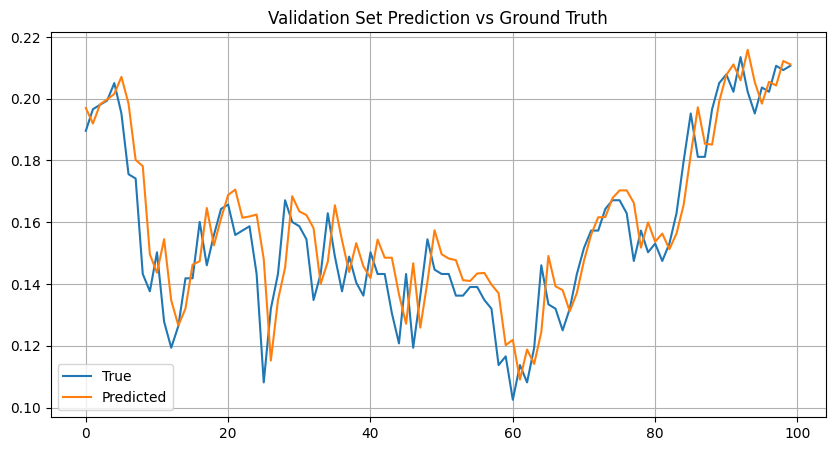

✅ Plot saved to outputs/lstm_model_val_predictions.png
📊 Validation Set Prediction vs Ground Truth Metrics:
 - MSE   : 0.000175
 - MAE   : 0.009444
 - SMAPE : 34.45%


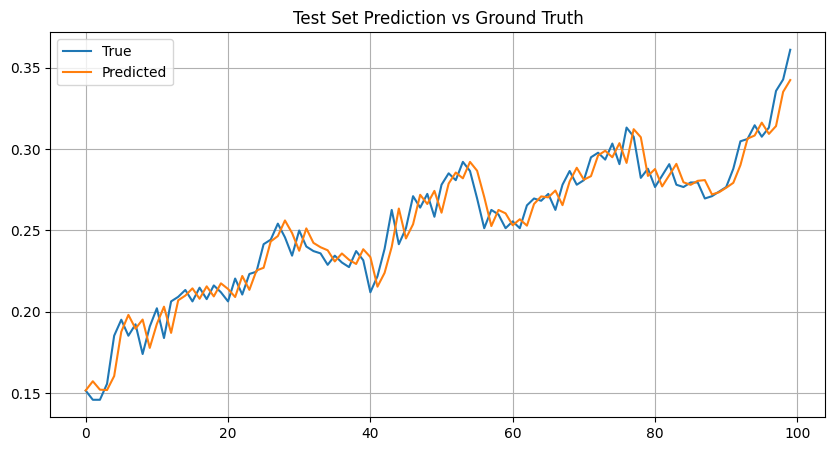

✅ Plot saved to outputs/lstm_model_test_predictions.png
📊 Test Set Prediction vs Ground Truth Metrics:
 - MSE   : 0.000171
 - MAE   : 0.008579
 - SMAPE : 18.71%


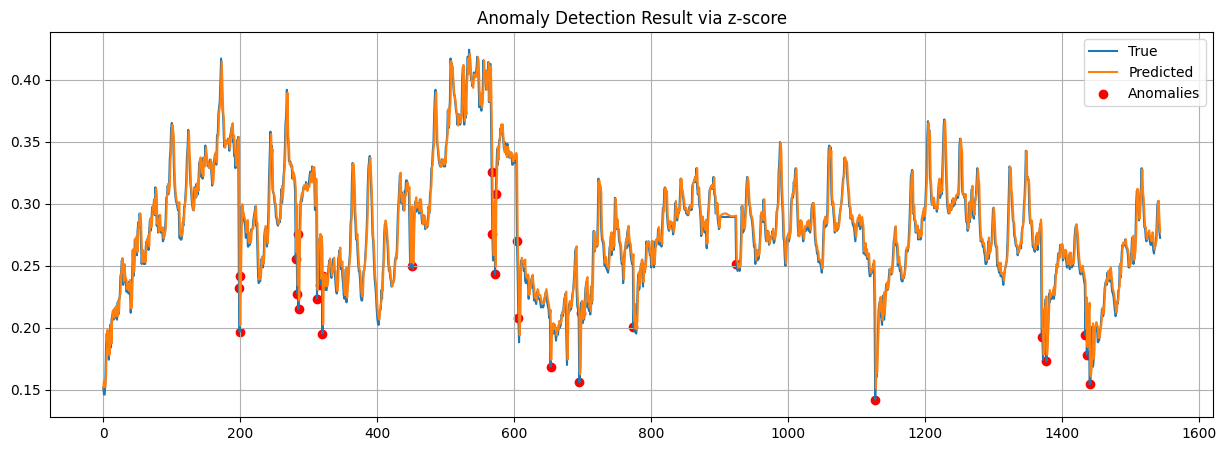

✅ Anomaly plot saved to anomaly_detection_visual_z_score.png
⚠️ Anomaly at index 198 → True: 0.23, Predicted: 0.35, Z-score: 11.49
⚠️ Anomaly at index 199 → True: 0.20, Predicted: 0.24, Z-score: 3.19
⚠️ Anomaly at index 200 → True: 0.24, Predicted: 0.20, Z-score: 3.16
⚠️ Anomaly at index 281 → True: 0.26, Predicted: 0.31, Z-score: 4.87
⚠️ Anomaly at index 283 → True: 0.23, Predicted: 0.30, Z-score: 6.43
🔎 Detected 29 anomalies in the test set


In [19]:
# Final evaluation
writer = SummaryWriter(log_dir="../runs/LSTM_Model/lstm_eval_final")
preds, trues = evaluate_model(model, val_loader, "Validation Set Prediction vs Ground Truth", "lstm_model_val_predictions.png", writer, step=0)
preds_test, trues_test = evaluate_model(model, test_loader, "Test Set Prediction vs Ground Truth", "lstm_model_test_predictions.png", writer, step=1)

# Anomaly detection with z-score
z_score_anomalies, z_score = anomaly_score(trues_test, preds_test)
print(f"🔎 Detected {len(z_score_anomalies)} anomalies in the test set")

# Save anomalies and z-scores
np.save("../../outputs/LSTM_Model/z_score_anomaly_indices.npy", z_score_anomalies)
np.save("../../outputs/LSTM_Model/z_scores.npy", z_score)

🌪️ Detected 16 anomalies using Isolation Forest


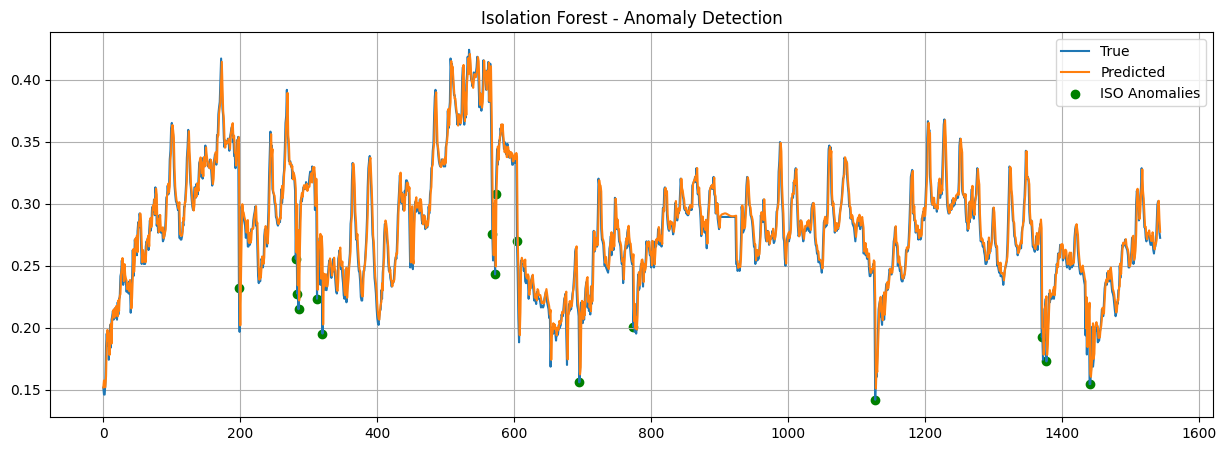

✅ Isolation Forest anomaly plot saved to: ../../outputs/LSTM_Model/isolation_forest_anomaly_plot.png
🌪️ ISO Anomaly at index 198 → True: 0.23, Predicted: 0.35, Residual: 0.12
🌪️ ISO Anomaly at index 281 → True: 0.26, Predicted: 0.31, Residual: 0.06
🌪️ ISO Anomaly at index 283 → True: 0.23, Predicted: 0.30, Residual: 0.07
🌪️ ISO Anomaly at index 285 → True: 0.21, Predicted: 0.28, Residual: 0.06
🌪️ ISO Anomaly at index 312 → True: 0.22, Predicted: 0.30, Residual: 0.08


In [20]:
# Isolation Forest anomaly detection

# convert preds_test and trues_test to 1D array with squeeze or flatten

if preds_test.ndim > 1:
    preds_test = preds_test.squeeze()
if trues_test.ndim > 1:
    trues_test = trues_test.squeeze()

residuals = np.abs(trues_test - preds_test)

iso_anomalies = isolation_forest_detection(residuals)

print(f"🌪️ Detected {len(iso_anomalies)} anomalies using Isolation Forest")

visualize_isolation_forest_anomalies(trues_test, preds_test, iso_anomalies)

# Close the TensorBoard writer

writer.close()

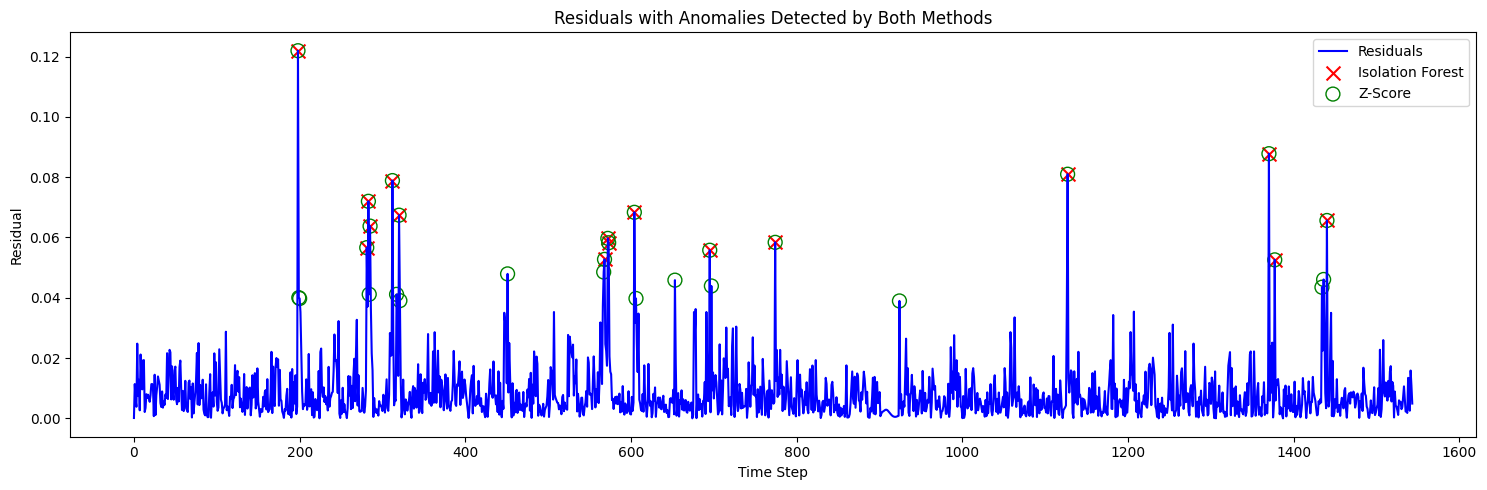

In [21]:
# Compare both anomaly detection methods (e.g., IForest & Z-Score) in one plot

# Ensure residuals is a NumPy array
residuals_np = residuals if isinstance(residuals, np.ndarray) else residuals.values
iso_anomalies_np = iso_anomalies if isinstance(iso_anomalies, np.ndarray) else iso_anomalies.values
zscore_anomalies_np = z_score_anomalies if isinstance(z_score_anomalies, np.ndarray) else z_score_anomalies.values

# Use np.arange for time steps
time_steps = np.arange(len(residuals_np))

plt.figure(figsize=(15, 5))
plt.plot(time_steps, residuals_np, label='Residuals', color='blue')

# Plot isolation forest anomalies
plt.scatter(time_steps[iso_anomalies_np], residuals_np[iso_anomalies_np],
            color='red', marker='x', label='Isolation Forest',s=100)

# Plot z-score anomalies
plt.scatter(time_steps[zscore_anomalies_np], residuals_np[zscore_anomalies_np],
            color='green', marker='o', label='Z-Score', facecolors='none',s=100)

plt.title("Residuals with Anomalies Detected by Both Methods")
plt.xlabel("Time Step")
plt.ylabel("Residual")
plt.legend()
plt.tight_layout()
plt.savefig("../../outputs/LSTM_Model/compare_anomaly_detection_methods.png")
plt.show()



📊 Final Evaluation Metrics:


C:\Users\aastm-sw\AppData\Local\Temp\ipykernel_13488\1885338416.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_df['Metric'], rotation=45, ha='right')


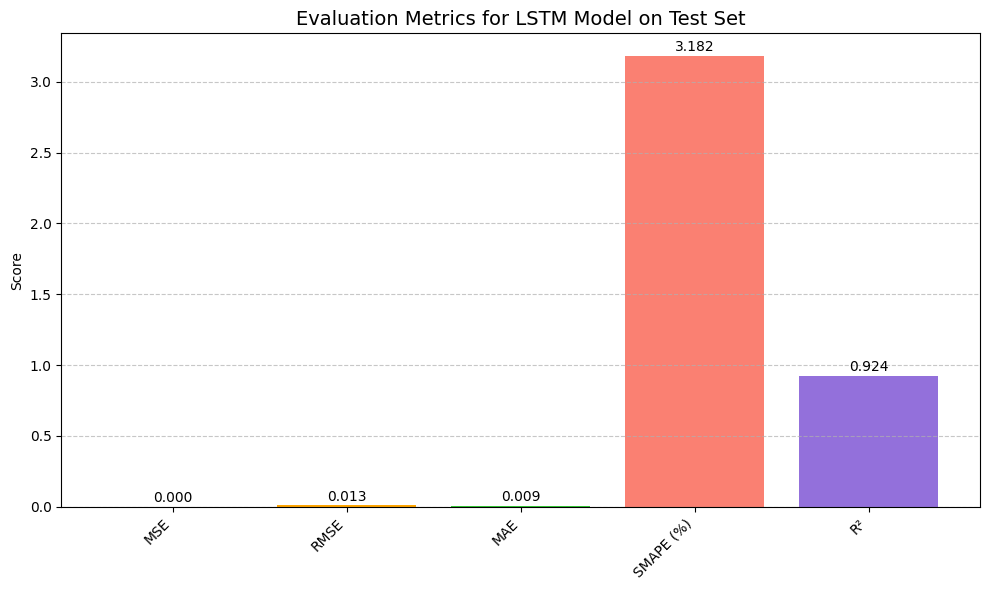

In [22]:
# calculate prediction accuracy and anomaly detection metrics
print("\n📊 Final Evaluation Metrics:")

preds_test = preds_test.flatten()
trues_test = trues_test.flatten()

mse= mean_squared_error(trues_test, preds_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(trues_test, preds_test)
r2 = r2_score(trues_test, preds_test)

smape_val = smape(trues_test, preds_test)

metrics_data = { 
    'Metric': ['MSE', 'RMSE', 'MAE', 'SMAPE (%)', 'R²'],
    'Score': [mse, rmse, mae, smape_val, r2]
}

# 'Anomalies_Z_Score','Anomalies_ISO_Forest' 
# len(z_score_anomalies), len(iso_anomalies)

metrics_df = pd.DataFrame(metrics_data)

colors = ['skyblue', 'orange', 'limegreen', 'salmon', 'mediumpurple', 'lightcoral', 'gold']

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xticklabels(metrics_df['Metric'], rotation=45, ha='right')
bars = ax.bar(metrics_df['Metric'], metrics_df['Score'], color=colors)

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

ax.set_title('Evaluation Metrics for LSTM Model on Test Set', fontsize=14)
ax.set_ylabel('Score')
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 ROC AUC Score: 1.0000


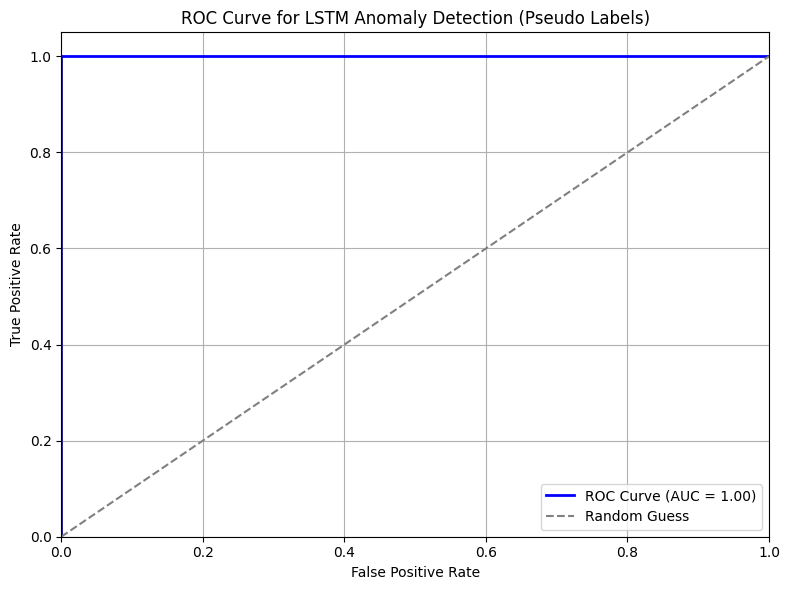

In [23]:
y_true = np.zeros_like(residuals)
y_true[iso_anomalies] = 1  # 1 = anomaly, 0 = normal

#Use residuals as anomaly scores
y_scores = residuals

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print(f" ROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LSTM Anomaly Detection (Pseudo Labels)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:

# make above operations for precision, recall and f1-score

# print("trues_test :", trues_test)

# print("preds_test :", preds_test)

# pred_residuals = np.abs(trues_test - preds_test)

# # Step 2: Create pseudo-ground-truth by thresholding true values
# # Here we assume large changes in actual values mean real anomalies
# true_residuals = np.abs(trues_test - np.mean(trues_test))
# anomaly_threshold = np.percentile(true_residuals, 95)  # top 5% residuals = anomalies
# true_binary_labels = (true_residuals > anomaly_threshold).astype(int)

# # Step 3: ROC curve
# fpr, tpr, thresholds = roc_curve(true_binary_labels, pred_residuals)
# auc_score = roc_auc_score(true_binary_labels, pred_residuals)

# # Step 4: Plot
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color='blue')
# plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Unsupervised Anomaly Detection (ETTh1 - OT)')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f"AUC Score: {auc_score:.4f}")



1. Inject synthetic anomalies into the OT column of ETTh1
   - Why? Since the original dataset has no labels, you artificially inject anomalies (e.g., spikes, drops, out-of-distribution values) to create known positions of anomalies, i.e., y_true.

2. Train your LSTM model on the original (clean) ETTh1
   - This gives the model a sense of what "normal" time-series behavior looks like.

3. Evaluate on the anomaly-injected version of the dataset
   - Feed the injected dataset through the LSTM model to get predicted values.

   - Calculate residuals (absolute difference between prediction and actual).

   - These residuals serve as anomaly scores → y_scores.

4. Use the injected anomaly positions as ground-truth (y_true)
   - The y_true is a binary array where injected anomaly indices are 1, all others 0.

   - Use y_scores and y_true for:

        - roc_auc_score

        - precision_recall_curve

        - f1_score, precision, recall

        - confusion_matrix




“How do I know that the injected data contains anomalies?”

You create and control the anomalies yourself — so you define where they are and what kind they are. These synthetic changes become your ground-truth anomaly labels (y_true). The types of anomalies can include:

    -  Point anomalies: Inject random spikes or dips (e.g., multiply a value by 2x or set to 0)

    -  Contextual anomalies: Break seasonality by shifting values only in specific time windows

    -  Collective anomalies: Introduce a sequence of values that deviate from normal patterns



In [25]:
def inject_anomalies(data, anomaly_fraction=0.02, seed=42):
    np.random.seed(seed)
    n = len(data)
    total_anomaly_count = int(anomaly_fraction * n)

    # keep original data
    original_data = data.copy()
    anomaly_labels = np.zeros(n)
    anomaly_types = np.array(["normal"] * n, dtype=object)

    # Basic stats
    data_mean = np.mean(data)
    data_std = np.std(data)

    # Allocate anomalies by expected impact size
    # point: 1 point per injection
    # contextual: 1 point per injection
    # collective: 5 points per injection


    # Anomaly types: KEYNOTE
    # -  Point anomalies: Inject random spikes or dips (e.g., multiply a value by 2x or set to 0)
    # -  Contextual anomalies: Break seasonality by shifting values only in specific time windows
    # -  Collective anomalies: Introduce a sequence of values that deviate from normal patterns

    point_budget = int(0.3 * total_anomaly_count)
    contextual_budget = int(0.3 * total_anomaly_count)
    collective_budget = total_anomaly_count - point_budget - contextual_budget

    # --- Point anomalies ---
    indices_point = np.random.choice(n, size=point_budget, replace=False)
    data[indices_point] += np.random.normal(
        loc=1.5 * data_mean, scale=0.3 * data_std, size=point_budget
    )
    anomaly_labels[indices_point] = 1
    anomaly_types[indices_point] = "point"

    # --- Contextual anomalies ---
    window_size = 12
    indices_contextual = np.random.choice(
        range(window_size, n - window_size), size=contextual_budget, replace=False
    )
    for idx in indices_contextual:
        local_mean = np.mean(data[idx - window_size : idx])
        data[idx] = local_mean + np.random.normal(
            loc=0.8 * data_std, scale=0.2 * data_std
        )
        anomaly_labels[idx] = 1
        anomaly_types[idx] = "contextual"

    # --- Collective anomalies ---
    collective_seq_length = 5
    collective_count = collective_budget // collective_seq_length
    indices_collective = np.random.choice(
        range(n - collective_seq_length), size=collective_count, replace=False
    )
    for idx in indices_collective:
        anomaly_sequence = np.random.normal(
            loc=data_mean + 1.0 * data_std, scale=0.3 * data_std, size=5
        )
        data[idx : idx + 5] = anomaly_sequence
        anomaly_labels[idx : idx + 5] = 1
        anomaly_types[idx : idx + 5] = "collective"

    return original_data, data, anomaly_labels, anomaly_types


In [26]:
def plot_anomalies_with_colors(original_data, injected_data, types):
    plt.figure(figsize=(15, 5))

    # Plot original data line
    plt.plot(
        original_data,
        label="Original Test Data",
        color="green",
        alpha=0.9,
        linewidth=1.2,
        zorder=1,
    )

    # Highlight only anomaly points with scatter plots in different colors
    anomaly_colors = {"point": "red", "contextual": "orange", "collective": "pink"}

    for anomaly_type, color in anomaly_colors.items():
        indices = np.where(types == anomaly_type)[0]
        if len(indices) > 0:
            plt.scatter(
                indices,
                injected_data[indices],
                label=f"{anomaly_type.capitalize()} Anomaly",
                color=color,
                s=50,
                linewidths=0.7,
                edgecolors="black",
                zorder=3,
            )

    plt.title("ETTh1 - Test Data with Injected Anomalies Highlighted")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

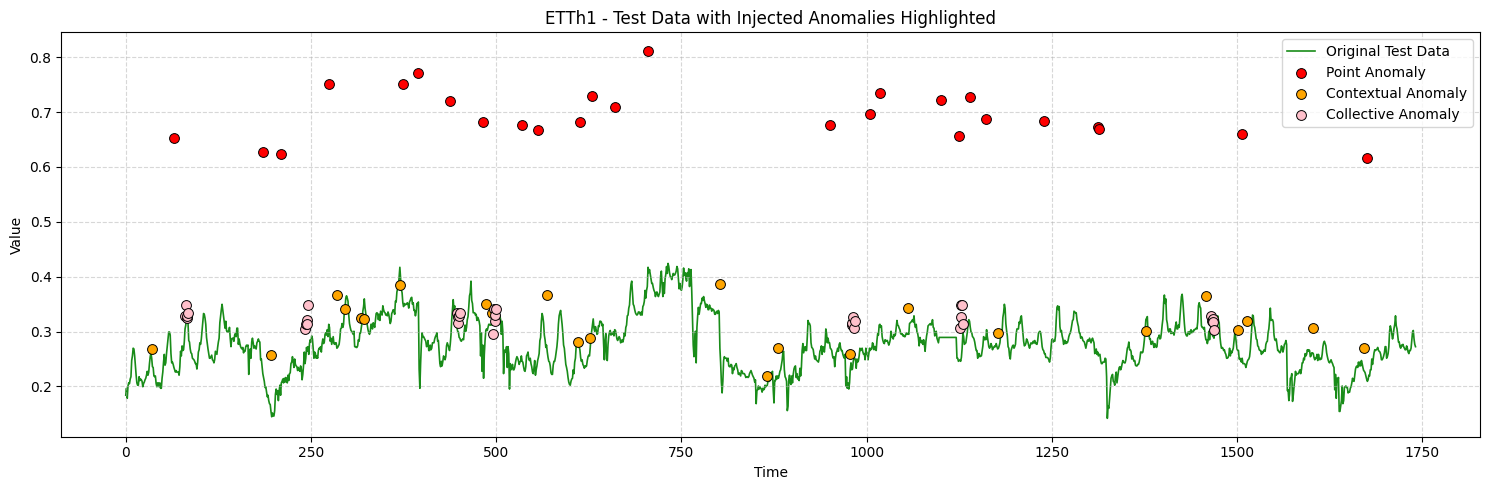

In [27]:
test_df = pd.read_csv("../data/processed/etth1_test.csv", parse_dates=["date"], index_col="date")

raw_test = test_df["OT"].values.copy()

#inject anomalies into the test set
original_test_data, test_data_with_anomalies, anomaly_labels, anomaly_types = inject_anomalies(raw_test.copy(), anomaly_fraction=0.05)

plot_anomalies_with_colors(original_test_data, test_data_with_anomalies, anomaly_types)

# Save the modified test data with anomalies
np.save("../data/processed/etth1_test_with_anomalies.npy", test_data_with_anomalies)

# Save the anomaly labels
np.save("../data/processed/etth1_anomaly_labels.npy", anomaly_labels)

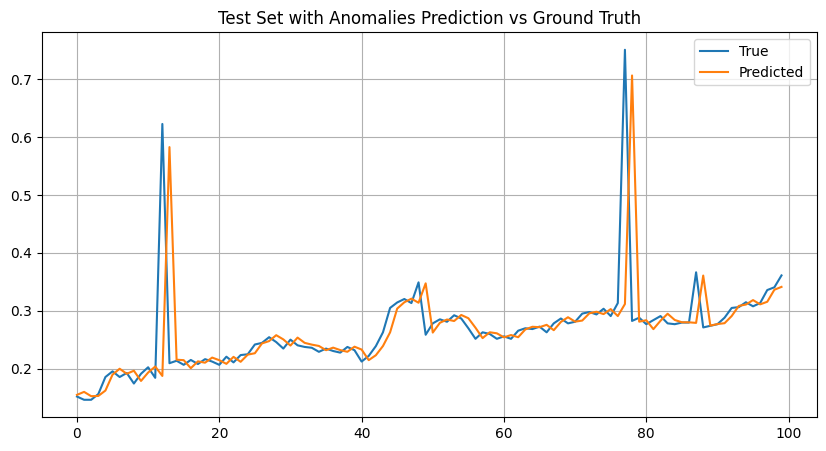

✅ Plot saved to outputs/lstm_model_test_with_anomalies_predictions.png
📊 Test Set with Anomalies Prediction vs Ground Truth Metrics:
 - MSE   : 0.005242
 - MAE   : 0.022056
 - SMAPE : 20.88%


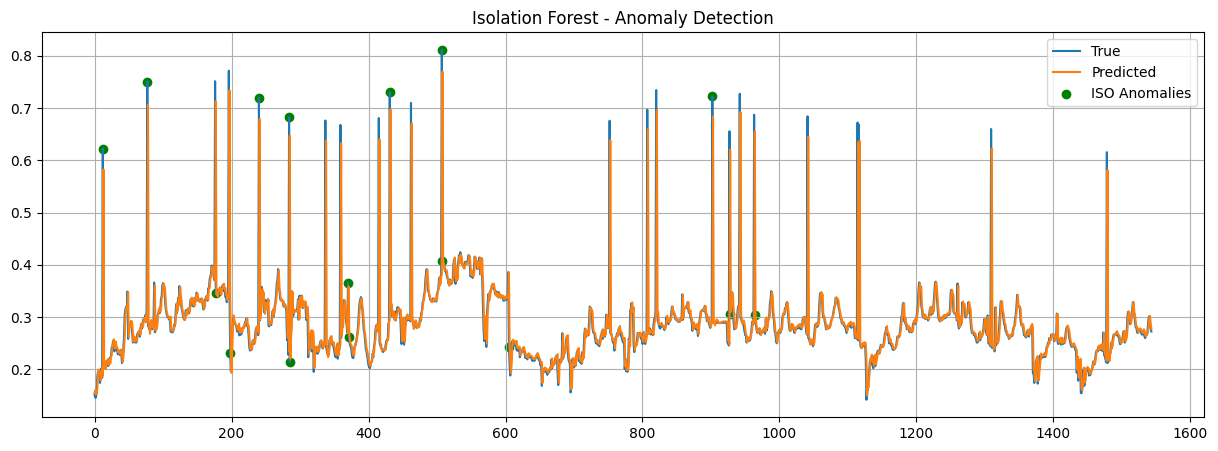

✅ Isolation Forest anomaly plot saved to: ../../outputs/LSTM_Model/isolation_forest_anomaly_plot.png
🌪️ ISO Anomaly at index 12 → True: 0.62, Predicted: 0.19, Residual: 0.44
🌪️ ISO Anomaly at index 77 → True: 0.75, Predicted: 0.31, Residual: 0.44
🌪️ ISO Anomaly at index 177 → True: 0.35, Predicted: 0.71, Residual: 0.37
🌪️ ISO Anomaly at index 198 → True: 0.23, Predicted: 0.35, Residual: 0.12
🌪️ ISO Anomaly at index 240 → True: 0.72, Predicted: 0.27, Residual: 0.45
ROC AUC Score on Modified Test Set: 0.8550


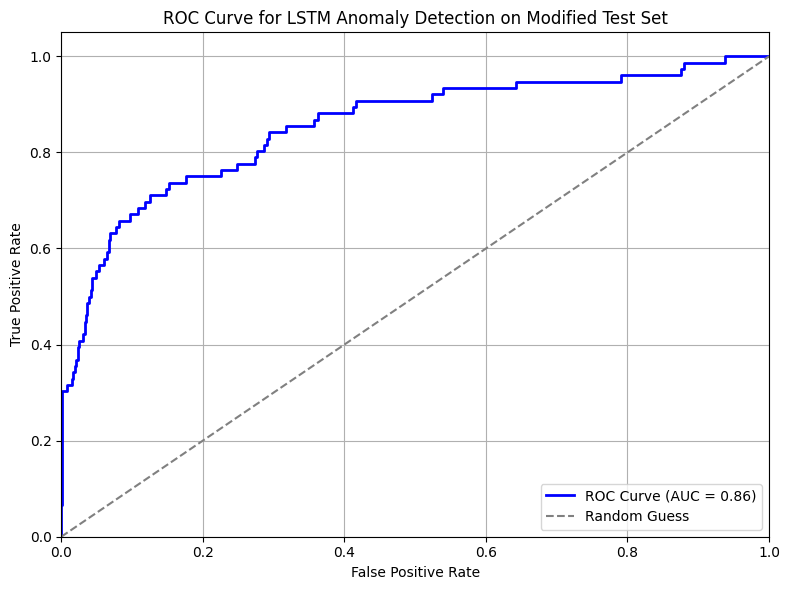

In [28]:

# Create a new DataLoader for the modified test set
test_loader_with_anomalies = DataLoader(TimeSeriesDataset(test_data_with_anomalies, window_size), batch_size=batch_size, shuffle=False)

# Evaluate the model on the modified test set with anomalies
preds_with_anomalies, trues_with_anomalies = evaluate_model(model, test_loader_with_anomalies, "Test Set with Anomalies Prediction vs Ground Truth", "lstm_model_test_with_anomalies_predictions.png", writer, step=2)


# isolation forest anomaly detection on the modified test set
# convert preds_with_anomalies and trues_with_anomalies to 1D array
if preds_with_anomalies.ndim > 1:
    preds_with_anomalies = preds_with_anomalies.squeeze()
if trues_with_anomalies.ndim > 1:
    trues_with_anomalies = trues_with_anomalies.squeeze()
# calculate residuals
residuals_with_anomalies = np.abs(trues_with_anomalies - preds_with_anomalies)
# Isolation Forest anomaly detection on the modified test set
iso_anomalies_with_anomalies = isolation_forest_detection(residuals_with_anomalies)
# Visualize Isolation Forest anomalies on the modified test set
visualize_isolation_forest_anomalies(trues_with_anomalies, preds_with_anomalies, iso_anomalies_with_anomalies)


# get true targets (shifted by window size)
trues_targets = test_data_with_anomalies[window_size:]
true_labels = anomaly_labels[window_size:]

# residuals

residuals=np.abs(preds_with_anomalies - trues_targets)

# ROC AUC

fpr, tpr, thresholds = roc_curve(true_labels, residuals)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC Score on Modified Test Set: {roc_auc:.4f}")

# Plot ROC Curve for modified test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LSTM Anomaly Detection on Modified Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("../../outputs/LSTM_Model/roc_curve_modified_test_set.png")
plt.show()

In [29]:
# calculation of precision, recall and f1-score

# Set threshold using top 5% of residuals
threshold = np.percentile(residuals, 95)

# Predict anomalies using threshold
predicted_labels = (residuals > threshold).astype(int)

# Precision, Recall, F1
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.4103
Recall:    0.4211
F1 Score:  0.4156


In [30]:
# === 1. Search for Best Threshold ===
best_f1 = 0
best_thresh = 0
thresholds = np.linspace(residuals.min(), residuals.max(), 500)

for thresh in thresholds:
    preds = (residuals > thresh).astype(int)
    f1 = f1_score(true_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"✅ Best Threshold: {best_thresh:.4f}")
print(f"✅ Max F1 Score:  {best_f1:.4f}")

# === 2. Use Best Threshold to Classify ===
predicted_labels = (residuals > best_thresh).astype(int)

# === 3. Compute Final Metrics ===
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# === 4. Plot Precision-Recall Curve ===
precision_vals, recall_vals, _ = precision_recall_curve(true_labels, residuals)
ap_score = average_precision_score(true_labels, residuals)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='darkorange', lw=2, label=f'AP={ap_score:.4f}')
plt.axvline(x=recall, color='gray', linestyle='--', label=f'Recall@Best={recall:.2f}')
plt.axhline(y=precision, color='gray', linestyle='--', label=f'Precision@Best={precision:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Residuals as Scores)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === 5. Plot Confusion Matrix ===
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix @ Best Threshold ({best_thresh:.4f})")
plt.grid(False)
plt.tight_layout()
plt.show()

✅ Best Threshold: 0.3954
✅ Max F1 Score:  0.4554
Precision: 0.9200
Recall:    0.3026
F1-Score:  0.4554


NameError: name 'precision_recall_curve' is not defined